# **Deep Learning Course - HW2-Q1**

---

### **Student Information:**

- **Name:** *Ali Soltani*
- **Student Number:** *403203449*



# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise, you will implement a dropout layer and modify your fully connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


## Loading Data:
This cell loads the CIFAR-10 dataset.
It flattens the images, splits them into training, validation, and test sets,
and normalizes the data by subtracting the mean image.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    import torchvision
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    X_train_all = trainset.data.astype(np.float32)   # (50000, 32, 32, 3)
    y_train_all = np.array(trainset.targets, dtype=np.int64)
    X_test_all  = testset.data.astype(np.float32)    # (10000, 32, 32, 3)
    y_test_all  = np.array(testset.targets, dtype=np.int64)

    # train/val split
    X_train = X_train_all[:num_training]
    y_train = y_train_all[:num_training]
    X_val   = X_train_all[num_training:num_training+num_validation]
    y_val   = y_train_all[num_training:num_training+num_validation]

    X_test = X_test_all[:num_test]
    y_test = y_test_all[:num_test]

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val   = X_val.reshape(X_val.shape[0], -1)
    X_test  = X_test.reshape(X_test.shape[0], -1)

    mean_image = np.mean(X_train, axis=0, keepdims=True)
    X_train -= mean_image
    X_val   -= mean_image
    X_test  -= mean_image

    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val':   X_val,   'y_val':   y_val,
        'X_test':  X_test,  'y_test':  y_test
    }

data = get_CIFAR10_data()
for k, v in data.items():
    print(f"{k}: {v.shape}")


100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


X_train: (49000, 3072)
y_train: (49000,)
X_val: (1000, 3072)
y_val: (1000,)
X_test: (10000, 3072)
y_test: (10000,)


## Gradients Computation:
Here we compute gradients numerically (using tiny finite differences) to check whether our analytical gradients from backprop are correct.

In [3]:
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=1e-5):
    fx = f(x)
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h
        fxph = f(x)
        x[ix] = oldval - h
        fxmh = f(x)
        x[ix] = oldval
        grad[ix] = (fxph - fxmh) / (2 * h)
        if verbose:
            print(ix, grad[ix])
        it.iternext()
    return grad

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h; pos = f(x).copy()
        x[ix] = oldval - h; neg = f(x).copy()
        x[ix] = oldval
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad



## Optimization:
sgd and adam update the model’s weights using gradient descent.

In [4]:
import numpy as np

def sgd(w, dw, config=None):
    if config is None: config = {}
    lr = config.get('learning_rate', 1e-2)
    w -= lr * dw
    return w, config

def adam(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config['t'] = config.get('t', 0) + 1

    lr, b1, b2, eps = config['learning_rate'], config['beta1'], config['beta2'], config['epsilon']
    m, v, t = config['m'], config['v'], config['t']

    m = b1 * m + (1 - b1) * dw
    v = b2 * v + (1 - b2) * (dw * dw)
    m_unbias = m / (1 - b1 ** t)
    v_unbias = v / (1 - b2 ** t)
    w -= lr * m_unbias / (np.sqrt(v_unbias) + eps)

    config['m'], config['v'] = m, v
    return w, config


## Solver:
Solver manages training — sampling minibatches, computing loss/gradients, updating weights, and tracking accuracy.


In [5]:
import os
import pickle as pickle
import numpy as np

import types
optim = types.SimpleNamespace(sgd=sgd, adam=adam)

class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification models.
    """
    def __init__(self, model, data, **kwargs):
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)
        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)
        self._reset()

    def _reset(self):
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]
        num_batches = N // batch_size + (1 if N % batch_size else 0)
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        return np.mean(y_pred == y)

    def train(self):
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch
        for t in range(num_iterations):
            self._step()
            if self.verbose and t % self.print_every == 0:
                print(f"(Iteration {t+1} / {num_iterations}) loss: {self.loss_history[-1]:.6f}")
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay
            first_it = t == 0
            last_it  = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train, num_samples=self.num_train_samples)
                val_acc   = self.check_accuracy(self.X_val,   self.y_val,   num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()
                if self.verbose:
                    print(f"(Epoch {self.epoch} / {self.num_epochs}) train acc: {train_acc:.3f}; val_acc: {val_acc:.3f}")
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {k: v.copy() for k, v in self.model.params.items()}
        self.model.params = self.best_params


## Basic building blocks:

In [6]:
import numpy as np

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.
    Inputs:
      - x: Input data of shape (N, D) or any shape that can be reshaped to (N, D)
      - w: Weights of shape (D, M)
      - b: Biases of shape (M,)
    Returns:
      - out: Output of shape (N, M)
      - cache: (x, w, b, x_shape) for backward
    """
    x_shape = x.shape
    N = x_shape[0]
    x_row = x.reshape(N, -1)          # (N, D)
    out = x_row.dot(w) + b            # (N, M)
    cache = (x, w, b, x_shape)
    return out, cache


def affine_backward(dout, cache):
    """
    Backward pass for the affine layer.
    Inputs/Outputs shapes match affine_forward.
    """
    x, w, b, x_shape = cache
    N = x_shape[0]
    x_row = x.reshape(N, -1)          # (N, D)

    dW = x_row.T.dot(dout)            # (D, M)
    db = np.sum(dout, axis=0)         # (M,)
    dx_row = dout.dot(w.T)            # (N, D)
    dx = dx_row.reshape(x_shape)      # reshape back to original

    return dx, dW, db


def relu_forward(x):
    """
    ReLU forward: out = max(0, x)
    Returns out and cache=x for backward.
    """
    out = np.maximum(0, x)
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    ReLU backward: passes upstream gradient where x>0, zero otherwise.
    """
    x = cache
    dx = dout * (x > 0)
    return dx


def softmax_loss(x, y):
    """
    Softmax loss with numeric stability.
    Inputs:
      - x: Scores array of shape (N, C)
      - y: Labels array of shape (N,) with values in [0, C)
    Returns:
      - loss: Scalar
      - dx: Gradient of loss w.r.t. x (N, C)
    """
    shifted = x - np.max(x, axis=1, keepdims=True)   # (N, C)
    exp_scores = np.exp(shifted)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # (N, C)

    N = x.shape[0]
    correct_logprobs = -np.log(probs[np.arange(N), y] + 1e-12)  # avoid log(0)
    loss = np.sum(correct_logprobs) / N

    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N

    return loss, dx


# Dropout: Forward Pass
Here, we implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

In [7]:
import numpy as np

def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with:
        - p: Dropout keep probability (0 < p <= 1)
        - mode: 'train' or 'test'
        - seed: Optional seed for RNG (useful for deterministic checks)

    Outputs:
    - out: Array of the same shape as x
    - cache: Tuple (dropout_param, mask)
      In train mode, mask is the dropout mask used.
      In test mode, mask should be None.
    """
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask, out = None, None
    if mode == "train":
        #######################################################################
        # TODO: Implement inverted dropout forward pass.                      #
        # Create a dropout mask using np.random.rand, where each neuron is    #
        # kept with probability p. Scale the output by 1/p so that the        #
        # expected value of activations remains the same between train/test.  #
        #######################################################################
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask

    elif mode == "test":
        #######################################################################
        # TODO: During test time, do not apply dropout — just return x.       #
        #######################################################################
        out = x
        mask = None

    else:
        raise ValueError("dropout_param['mode'] must be 'train' or 'test'")

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)
    return out, cache


# Dropout: Backward Pass
Here, we implement the backward pass for dropout.

In [8]:
def dropout_backward(dout, cache):
    """Backward pass for inverted dropout.

    Inputs:
    - dout: Upstream gradients, same shape as input x
    - cache: Tuple of (dropout_param, mask) from dropout_forward

    Returns:
    - dx: Gradient of loss with respect to x
    """
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        #######################################################################
        # TODO: Backward pass for inverted dropout.                           #
        # Multiply upstream gradients by the same mask used in the forward    #
        # pass. Remember, in train mode the mask is not None.                 #
        #######################################################################
        dx = dout * mask

    elif mode == "test":
        #######################################################################
        # TODO: In test mode, dropout does nothing — just pass gradients on.  #
        #######################################################################
        dx = dout

    else:
        raise ValueError("dropout_param['mode'] must be 'train' or 'test'")

    return dx


## Check:
This section tests your dropout implementation to make sure it works correctly.
Check your results.

In [9]:
# === Dropout tests (forward means & zeros) ===
np.random.seed(231)
x = np.random.randn(500, 500) + 10
for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})
    print('Running tests with p = ', p)
    print('Mean of input:             ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output:  ', out_test.mean())
    print('Fraction train-time zeros: ', (out == 0).mean())
    print('Fraction test-time zeros:  ', (out_test == 0).mean())
    print()

# === Dropout gradient check ===
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)
dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)
print('dx relative error: ', rel_error(dx, dx_num))

Running tests with p =  0.25
Mean of input:              10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:   10.000207878477502
Fraction train-time zeros:  0.749784
Fraction test-time zeros:   0.0

Running tests with p =  0.4
Mean of input:              10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:   10.000207878477502
Fraction train-time zeros:  0.600796
Fraction test-time zeros:   0.0

Running tests with p =  0.7
Mean of input:              10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:   10.000207878477502
Fraction train-time zeros:  0.30074
Fraction test-time zeros:   0.0

dx relative error:  5.44560814873387e-11


# Fully Connected Networks with Dropout
In this section, you’ll implement a fully connected neural network that supports an arbitrary number of hidden layers and optional dropout regularization.
You’ll complete the initialization, forward pass, and backward pass functions.
The network should follow this structure:

> { affine → ReLU → [dropout] } × (L−1) → affine → softmax



In [12]:
import numpy as np

class FullyConnectedNet(object):
    """
    A fully connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and optional dropout.

    The architecture is:
    {affine - relu - [dropout]} x (L-1) - affine - softmax
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout_keep_ratio=1,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        self.use_dropout = (dropout_keep_ratio != 1)
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        #######################################################################
        # TODO: Initialize the parameters of the network.                     #
        # Store all weights and biases in self.params dictionary, using keys  #
        # 'W1', 'b1', 'W2', 'b2', ... , 'WL', 'bL'.                          #
        # Weights should be initialized from a normal distribution with       #
        # standard deviation = weight_scale, and biases should be zeros.      #
        #######################################################################
        dims = [input_dim] + list(hidden_dims) + [num_classes]
        for i in range(self.num_layers):
            W_name = f"W{i+1}"
            b_name = f"b{i+1}"
            self.params[W_name] = np.random.normal(scale=weight_scale, size=(dims[i], dims[i+1]))
            self.params[b_name] = np.zeros(dims[i+1])
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################

        # Dropout bookkeeping
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # Cast all parameters to the correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully connected net.

        Inputs:
        - X: Input data of shape (N, d_1, ..., d_k)
        - y: Labels, or None for test mode

        Returns:
        - If y is None: return classification scores
        - If y is not None: return (loss, grads)
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set the mode for dropout
        if self.use_dropout:
            self.dropout_param["mode"] = mode

        #######################################################################
        # TODO: Implement the forward pass for the fully connected net.       #
        # Store the output (scores) of the final layer in the variable scores. #
        # For each hidden layer, perform: affine -> relu -> [dropout].        #
        # Save any caches needed for the backward pass.                       #
        #######################################################################
        caches = {}   # store caches per layer (1-indexed)
        out = X
        # hidden layers
        for i in range(1, self.num_layers):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            # affine -> relu
            a_out, a_cache = affine_forward(out, W, b)
            r_out, r_cache = relu_forward(a_out)
            # optional dropout
            d_cache = None
            if self.use_dropout:
                r_out, d_cache = dropout_forward(r_out, self.dropout_param)
            caches[i] = (a_cache, r_cache, d_cache)
            out = r_out

        # final affine to produce scores
        W_last = self.params[f"W{self.num_layers}"]
        b_last = self.params[f"b{self.num_layers}"]
        scores, final_aff_cache = affine_forward(out, W_last, b_last)
        caches[self.num_layers] = (final_aff_cache,)
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################

        # If test mode, return early
        if mode == "test":
            return scores

        #######################################################################
        # TODO: Implement the backward pass. Compute both the loss and        #
        # gradients. Use softmax_loss to compute data loss, and add L2        #
        # regularization to the loss. Then backpropagate through the network, #
        # following the reverse of the forward pass sequence.                 #
        # Store gradients in the grads dictionary, with keys matching          #
        # the self.params keys.                                               #
        #######################################################################
        # softmax loss
        data_loss, dscores = softmax_loss(scores, y)
        loss = data_loss

        # L2 regularization for all weight matrices
        reg_loss = 0.0
        for i in range(1, self.num_layers + 1):
            W = self.params[f"W{i}"]
            reg_loss += 0.5 * self.reg * np.sum(W * W)
        loss += reg_loss

        # grads dict
        grads = {}

        # final affine backward
        final_cache = caches[self.num_layers][0]
        dout, dW, db = affine_backward(dscores, final_cache)
        grads[f"W{self.num_layers}"] = dW + self.reg * self.params[f"W{self.num_layers}"]
        grads[f"b{self.num_layers}"] = db

        # backprop through hidden layers in reverse
        for i in range(self.num_layers - 1, 0, -1):
            a_cache, r_cache, d_cache = caches[i]
            # dropout backward if used — pass the exact cache returned by dropout_forward
            if self.use_dropout and d_cache is not None:
                dout = dropout_backward(dout, d_cache)
            # relu backward
            dout = relu_backward(dout, r_cache)
            # affine backward
            dout, dW, db = affine_backward(dout, a_cache)
            grads[f"W{i}"] = dW + self.reg * self.params[f"W{i}"]
            grads[f"b{i}"] = db
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################

        return loss, grads


## Run:

In [13]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.300479089758513
W1 relative error: 2.42e-07
W2 relative error: 2.26e-04
W3 relative error: 1.09e-07
b1 relative error: 7.59e-09
b2 relative error: 8.44e-10
b3 relative error: 8.54e-11

Running check with dropout =  0.75
Initial loss:  2.302371489694414
W1 relative error: 1.85e-07
W2 relative error: 1.30e-06
W3 relative error: 3.31e-08
b1 relative error: 2.19e-09
b2 relative error: 1.82e-09
b3 relative error: 1.20e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220685727
W1 relative error: 1.20e-06
W2 relative error: 5.18e-08
W3 relative error: 6.43e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 7.36e-11



## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
If you skip the division by `p` in inverted dropout, the network’s expected activation magnitude changes between training and testing. During training, you randomly zero out units, but the surviving ones are left unchanged, meaning their average output becomes `p` times smaller than what the test-time network will produce. At test time, nothing is dropped, so activations suddenly jump to full strength.

That mismatch forces the network to learn on one scale and predict on another, which destabilizes training, hurts convergence, and makes the model behave unpredictably at inference. Dividing by `p` keeps the expected activation the same in both modes, so the network doesn’t need any special test-time scaling.


# Regularization Experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [14]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 8.760201
(Epoch 0 / 25) train acc: 0.286; val_acc: 0.199
(Epoch 1 / 25) train acc: 0.362; val_acc: 0.229
(Epoch 2 / 25) train acc: 0.482; val_acc: 0.273
(Epoch 3 / 25) train acc: 0.616; val_acc: 0.277
(Epoch 4 / 25) train acc: 0.666; val_acc: 0.262
(Epoch 5 / 25) train acc: 0.720; val_acc: 0.258
(Epoch 6 / 25) train acc: 0.790; val_acc: 0.271
(Epoch 7 / 25) train acc: 0.834; val_acc: 0.261
(Epoch 8 / 25) train acc: 0.842; val_acc: 0.268
(Epoch 9 / 25) train acc: 0.894; val_acc: 0.285
(Epoch 10 / 25) train acc: 0.920; val_acc: 0.255
(Epoch 11 / 25) train acc: 0.900; val_acc: 0.268
(Epoch 12 / 25) train acc: 0.920; val_acc: 0.278
(Epoch 13 / 25) train acc: 0.956; val_acc: 0.299
(Epoch 14 / 25) train acc: 0.950; val_acc: 0.297
(Epoch 15 / 25) train acc: 0.966; val_acc: 0.287
(Epoch 16 / 25) train acc: 0.992; val_acc: 0.274
(Epoch 17 / 25) train acc: 0.958; val_acc: 0.259
(Epoch 18 / 25) train acc: 0.972; val_acc: 0.296
(Epoch 19 / 25) train acc: 0.966; val_acc:

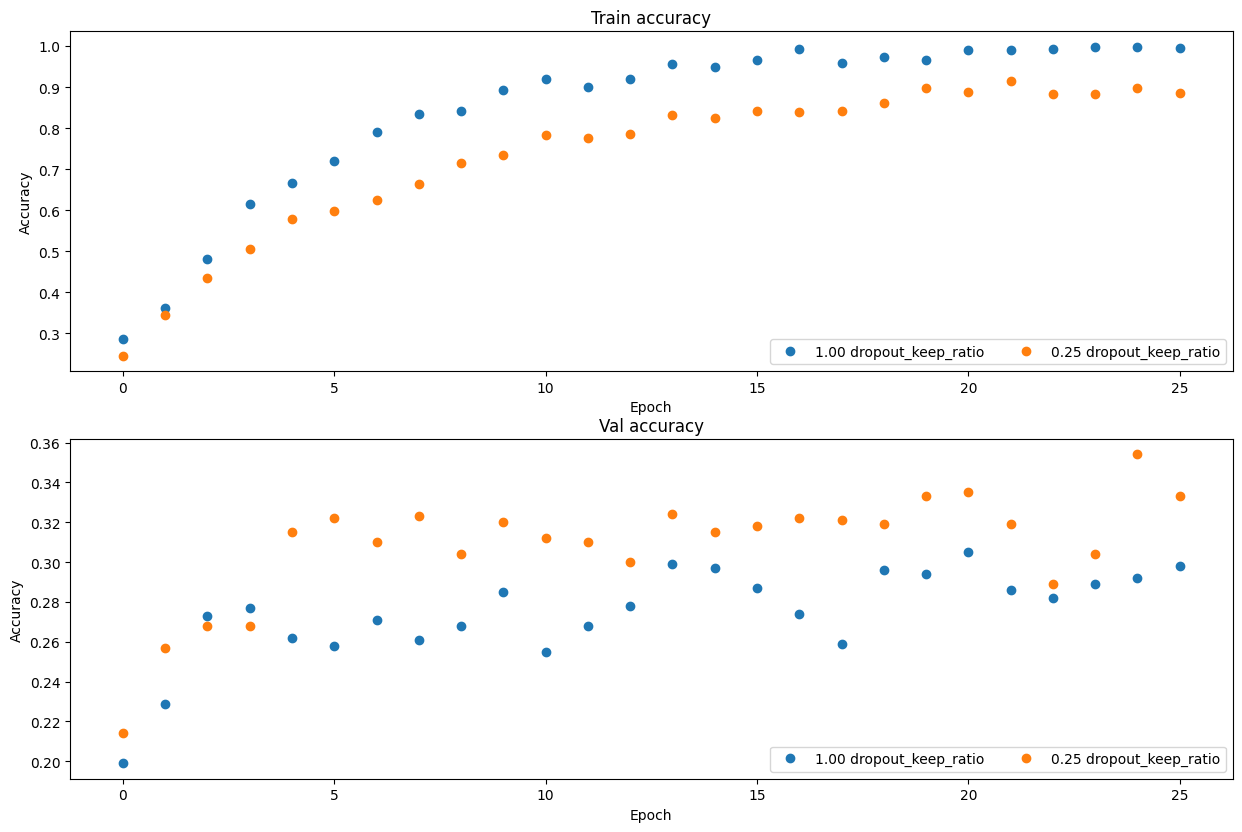

In [15]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
With no dropout, the network easily memorizes the small training set, so training accuracy becomes very high while validation accuracy lags behind. That’s overfitting.

With dropout, training accuracy is lower because many neurons are turned off at random, but validation accuracy improves. The model learns more robust features instead of memorizing the data.

The results show that dropout reduces overfitting and helps the network generalize better.
